## Imports 

In [1]:
import neurokit2 as nk
import numpy as np
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, Dense
from keras.models import Model

## Reading the csv's

In [2]:
csv_files = glob.glob('*.csv')

combined_data = pd.DataFrame()

for file in csv_files:
    try:
        df = pd.read_csv(file)        
        df.columns = df.columns.str.strip()
        
        if 'Solar8000/HR' in df.columns:
            df = df.rename(columns={'Solar8000/HR': 'HR'})
            combined_data = pd.concat([combined_data, df['HR']], ignore_index=True)
        else:
            print(f"Error: 'HR' column not found in the file {file}")
            
        print(f"\nFirst few rows of {file}:\n{df.head()}\n{'='*50}\n")
    except pd.errors.ParserError as e:
        print(f"Error processing the file {file}: {e}")



First few rows of 1590.csv:
   time  Primus/FLOW_N2O  BIS/EEG1_WAV  Primus/MAWP_MBAR  Primus/FLOW_O2  \
0   0.0              NaN           NaN               NaN             NaN   
1   1.0              NaN      0.000000               NaN             NaN   
2   2.0              NaN      0.007812               NaN             NaN   
3   3.0              0.0           NaN               NaN             0.0   
4   4.0              NaN           NaN               NaN             NaN   

   Primus/PIP_MBAR  Vigilance/EDV  Solar8000/VENT_MV  Primus/SET_INTER_PEEP  \
0              NaN            NaN                NaN                    NaN   
1              NaN            NaN                NaN                    NaN   
2              NaN            NaN                NaN                    NaN   
3              NaN            NaN                NaN                    NaN   
4              NaN            NaN                NaN                    NaN   

   Solar8000/FEM_DBP  ...  Primus/INCO2

In [3]:
combined_data = combined_data.dropna()

In [4]:
print(combined_data)

           0
4       67.0
6       67.0
8       67.0
10      67.0
12      67.0
...      ...
431604   0.0
431606   0.0
431608   0.0
431610   0.0
431612   0.0

[25217 rows x 1 columns]


## Plotting the combined HR Data

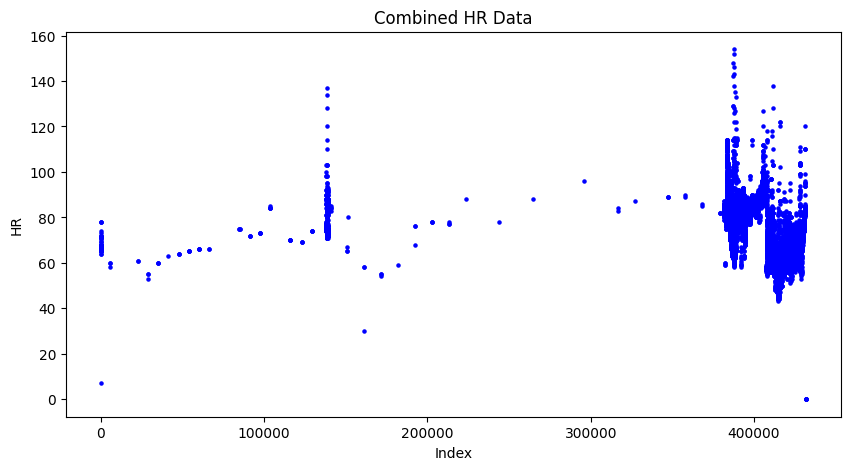

In [5]:
plt.figure(figsize=(10, 5))
plt.scatter(combined_data.index, combined_data.values, color='blue', s=5)
plt.title('Combined HR Data')
plt.xlabel('Index')
plt.ylabel('HR')
plt.show()

## Creating and trainning the autoencoder model

In [6]:
def create_and_train_autoencoder(input_data, epochs=10, batch_size=32):
    input_layer = Input(shape=(1,))
    encoded = Dense(64, activation='relu')(input_layer)
    decoded = Dense(1, activation='linear')(encoded)

    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    train_data, test_data = train_test_split(input_data, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    train_data_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
    test_data_scaled = scaler.transform(test_data.values.reshape(-1, 1))

    history = autoencoder.fit(train_data_scaled, train_data_scaled, epochs=epochs, batch_size=batch_size, shuffle=True, validation_split=0.3)

    encoded_data = autoencoder.predict(test_data_scaled)

    return history, test_data, encoded_data, autoencoder

In [7]:
history, test_data, encoded_hr_data, autoencoder = create_and_train_autoencoder(combined_data)



Epoch 1/10

442/442 [==============================] - 2s 2ms/step - loss: 0.1274 - val_loss: 0.0070
Epoch 2/10
442/442 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 2.1063e-04
Epoch 3/10
442/442 [==============================] - 1s 2ms/step - loss: 1.6590e-04 - val_loss: 5.7245e-05
Epoch 4/10
442/442 [==============================] - 1s 2ms/step - loss: 6.0262e-05 - val_loss: 1.6328e-05
Epoch 5/10
442/442 [==============================] - 1s 2ms/step - loss: 2.5385e-05 - val_loss: 1.4208e-05
Epoch 6/10
442/442 [==============================] - 1s 2ms/step - loss: 1.0254e-05 - val_loss: 3.9444e-06
Epoch 7/10
442/442 [==============================] - 1s 2ms/step - loss: 5.3785e-06 - val_loss: 1.5127e-06
Epoch 8/10
442/442 [==============================] - 1s 2ms/step - loss: 2.7261e-06 - val_loss: 9.6123e-07
Epoch 9/10
442/442 [==============================] - 1s 2ms/step - loss: 1.7614e-06 - val_loss: 7.6215e-07
Epoch 10/10
158/158 [================

## Validating the model

In [8]:
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]
print(f'Training Loss: {train_loss:.4f}')
print(f'Validation Loss: {val_loss:.4f}')

Training Loss: 0.0000
Validation Loss: 0.0000


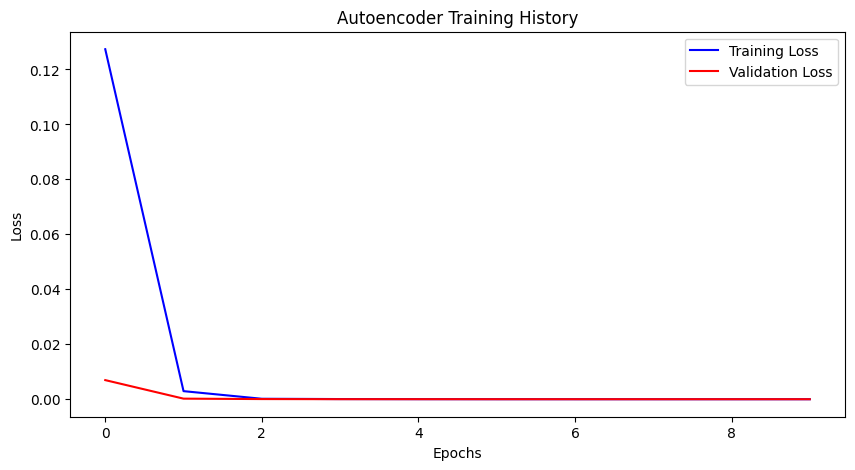

In [9]:
plt.figure(figsize=(10, 5))

plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Autoencoder Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Generating the HR

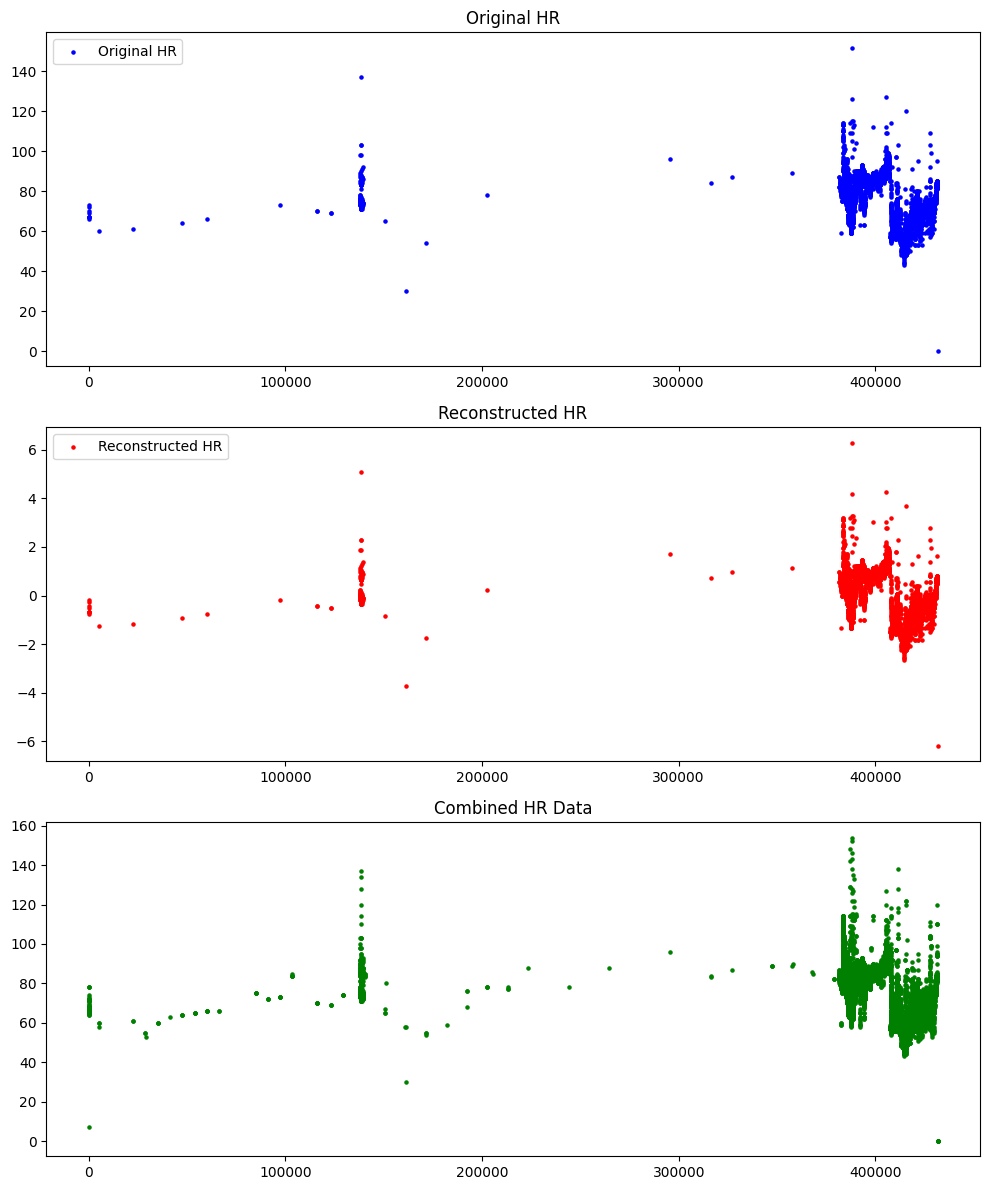

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

axes[0].scatter(test_data.index, test_data.values, label='Original HR', color='blue', s=5)
axes[0].set_title('Original HR')
axes[0].legend()

axes[1].scatter(test_data.index, encoded_hr_data, label='Reconstructed HR', color='red', s=5)
axes[1].set_title('Reconstructed HR')
axes[1].legend()

axes[2].scatter(combined_data.index, combined_data.values, color='green', s=5)
axes[2].set_title('Combined HR Data')

plt.tight_layout()
plt.show()